In [63]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from catboost import CatBoostRegressor
#from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)
#things we should do:
#Export data analysis
#accurate preprosessing, remove outliers
#strong model
#hyperparamter tuning and validation as times series validation is key thing here
#stacking, to merge diffrent strong models
#result analysis, what are the most important featurs
#lectures will give insights of how to these things
#find out what featurs that 

#tips fra gutta på sal<3
#bruke H20 AutoML
#bruke gjennomsnitt power output over en time istedenfor hver variabel



In [64]:
def list_directory_tree_with_os_walk(starting_directory):
    for root, directories, files in os.walk(starting_directory):
        print(f"Directory: {root}")
        for file in files:
            print(f"  File: {file}")

list_directory_tree_with_os_walk('.')

Directory: .
  File: .DS_Store
  File: catBoost.ipynb
  File: my_first_submission.csv
  File: Readme.md
  File: read_files.ipynb
  File: sample_submission.csv
  File: test.csv
Directory: .\A
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\B
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\C
  File: train_targets.parquet
  File: X_test_estimated.parquet
  File: X_train_estimated.parquet
  File: X_train_observed.parquet
Directory: .\catboost_info
  File: .DS_Store
  File: catboost_training.json
  File: learn_error.tsv
  File: test_error.tsv
  File: time_left.tsv
Directory: .\catboost_info\learn
  File: events.out.tfevents
Directory: .\catboost_info\test
  File: events.out.tfevents
Directory: .\catboost_info\tmp
  File: cat_feature_index.183104b5-642a4438-9869cb06-fbb87aec.tmp
  File: cat_feature_index.

time              datetime64[us]
pv_measurement           float64
dtype: object


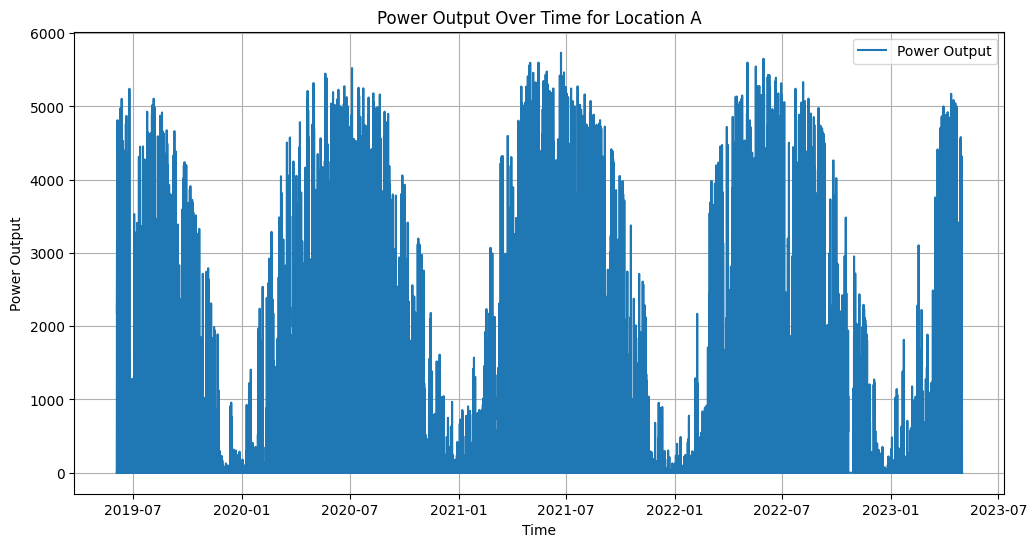

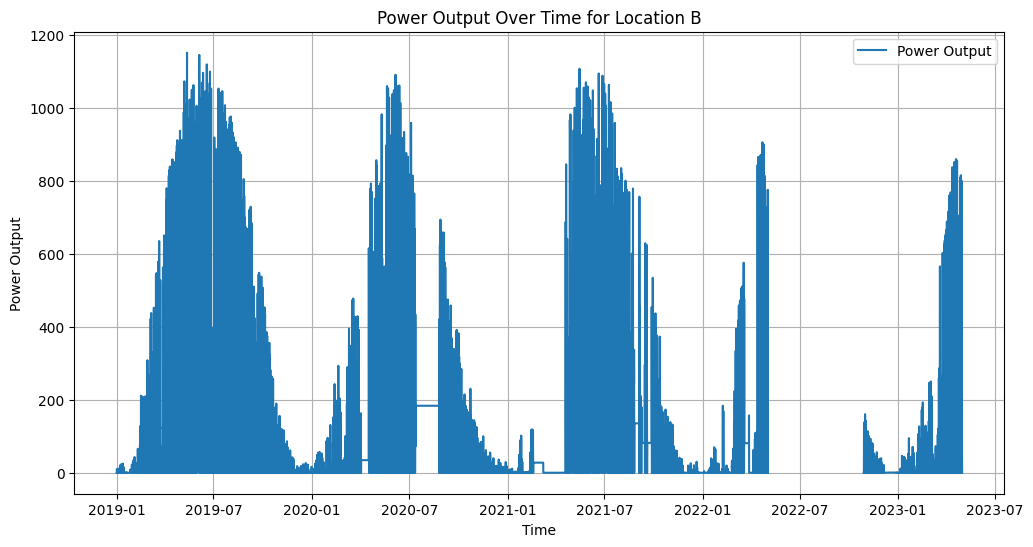

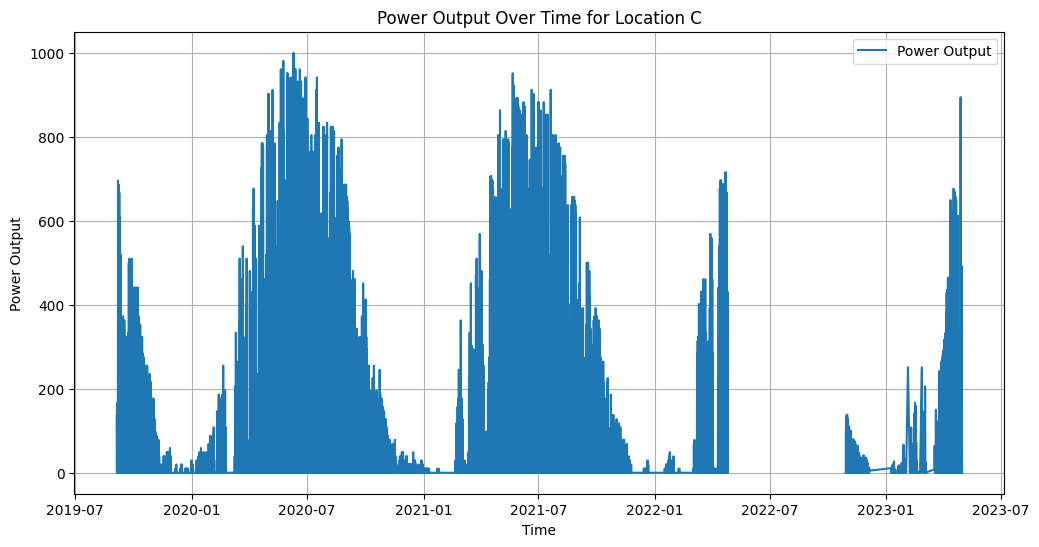

In [65]:
# Load your data
train_a = pd.read_parquet('A/train_targets.parquet')
train_b = pd.read_parquet('B/train_targets.parquet')
train_c = pd.read_parquet('C/train_targets.parquet')
print(train_a.dtypes)
# Function to plot time series data
def plot_time_series(df, title):
    plt.figure(figsize=(12,6))
    
    # Assuming 'time' is your time column and 'pv_measurement' is the power output measurement
    plt.plot(df['time'], df['pv_measurement'], label='Power Output')
    
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Power Output')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plotting the data
plot_time_series(train_a, 'Power Output Over Time for Location A')
plot_time_series(train_b, 'Power Output Over Time for Location B')
plot_time_series(train_c, 'Power Output Over Time for Location C')

X_train_estimated_a = pd.read_parquet('A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('C/X_test_estimated.parquet')

float64


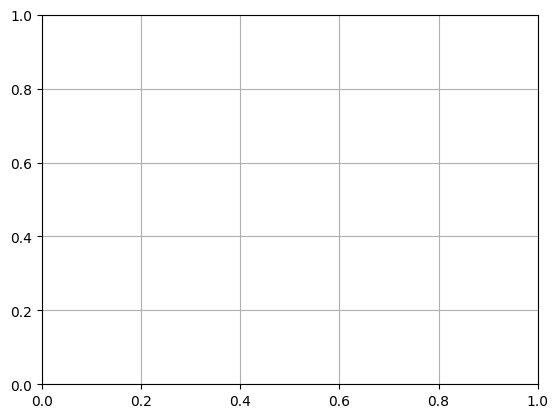

In [66]:
X_train_a = pd.concat([X_train_estimated_a, X_train_observed_a])

# Merge features and target data for location A
merged_data_a = pd.merge(X_train_a, train_a, left_on='date_forecast', right_on='time')

X_train_b = pd.concat([X_train_estimated_b, X_train_observed_b])

# Merge features and target data for location A
merged_data_b = pd.merge(X_train_b, train_b, left_on='date_forecast', right_on='time')

X_train_c = pd.concat([X_train_estimated_c, X_train_observed_c])

# Merge features and target data for location A
merged_data_c = pd.merge(X_train_c, train_c, left_on='date_forecast', right_on='time')


# Add location column
merged_data_a['location'] = 'A'
merged_data_b['location'] = 'B'
merged_data_c['location'] = 'C'

# List of features to convert to categorical
features_to_convert = ['dew_or_rime:idx', 'is_day:idx','is_in_shadow:idx']

# Convert features for X
for feature in features_to_convert:
    merged_data_a[feature] = merged_data_a[feature].astype(int)

# Convert features for X_b
for feature in features_to_convert:
    merged_data_b[feature] = merged_data_b[feature].astype(int)

# Convert features for X_c
for feature in features_to_convert:
    merged_data_c[feature] = merged_data_c[feature].astype(int)

# Combine the datasets
combined = pd.concat([merged_data_a, merged_data_b, merged_data_c])
#print(combined.isna().sum())
#Adding hour, day month and year as parameters in the model from dataforecast
combined['hour'] = combined['date_forecast'].dt.hour
combined['day'] = combined['date_forecast'].dt.day
combined['month'] = combined['date_forecast'].dt.month
combined['year'] = combined['date_forecast'].dt.year

complete_cases = combined.dropna(subset=['pv_measurement'])
incomplete_cases = combined[combined['pv_measurement'].isna()]

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Identify categorical features (you should update this list with your actual categorical feature names)
cat_features = ['location', 'dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx']

# Prepare your feature matrix (X) and target array (y)
X_complete = complete_cases.drop(columns=['pv_measurement', 'date_calc', 'date_forecast', 'time', 'snow_density:kgm3', 'ceiling_height_agl:m'])
y_complete = combined['pv_measurement']

# Split the data into training and validation sets
'''X_train, X_val, y_train, y_val = train_test_split(X_complete, y_complete, test_size=0.2, random_state=42)
print(X_train.dtypes)
# Initialize CatBoostRegressor
model = CatBoostRegressor(
    iterations=2000,  # you might want to tune this hyperparameter  # you might want to tune this hyperparameter
    depth=4,  # you might want to tune this hyperparameter
    cat_features=cat_features,
    verbose=200  # set to 0 to disable logging
)

# Train the model
model.fit(X_train, y_train, eval_set=(X_val, y_val))

# Validate the model
y_pred = model.predict(X_val)
print(f'Validation MSE: {mean_squared_error(y_val, y_pred)}')

X_incomplete = incomplete_cases.drop(columns=['pv_measurement', 'date_calc', 'date_forecast', 'time'])

# Predict the missing target values
y_predicted = model.predict(X_incomplete)

# Fill in the missing values in your original data
incomplete_cases['pv_measurement'] = y_predicted'''

# Combine the data back together
'''new_data = pd.concat([complete_cases, incomplete_cases])

#Splitting into X and Y values
y = new_data['pv_measurement']

X = new_data.drop(columns=['pv_measurement', 'date_calc', 'date_forecast', 'time'])'''
X = X_complete

y = y_complete
print(y.dtypes)
# Concatenate the time columns
'''combined_time = pd.concat([train_a['time'], train_b['time'], train_c['time']], ignore_index=True)

# Assuming y_complete is your DataFrame with 'pv_measurement' values
# y_complete = pd.read_parquet('path_to_your_combined_data.parquet')  # Use your actual path

# Create a new DataFrame for plotting
plot_data = pd.DataFrame({
    'time': combined_time,
    'pv_measurement': y_complete['pv_measurement']  # Ensure this column is properly aligned
})

plt.figure(figsize=(12,6))
# Plotting
plt.plot(plot_data['time'], plot_data['pv_measurement'], label='Power Output')

plt.title('Combined Power Output Over Time for Locations A, B, C')
plt.xlabel('Time')
plt.ylabel('Power Output')
plt.legend()'''
plt.grid(True)
plt.show()
#managing the test data
X_test_estimated_a['location'] = 'A'
X_test_estimated_b['location'] = 'B'
X_test_estimated_c['location'] = 'C'

features_to_convert = ['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx']

# Convert features for X_test_a
# Convert features for X_test_a
for feature in features_to_convert:
    X_test_estimated_a[feature] = X_test_estimated_a[feature].apply(lambda x: int(x) if not pd.isna(x) else x)


# Convert features for X_test_b
for feature in features_to_convert:
    X_test_estimated_b[feature] = X_test_estimated_b[feature].apply(lambda x: int(x) if not pd.isna(x) else x)

# Convert features for X_test_c
for feature in features_to_convert:
    X_test_estimated_c[feature] = X_test_estimated_c[feature].apply(lambda x: int(x) if not pd.isna(x) else x)

nan_replacement = "missing_value"
cat_features = ['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'location']
# Replace NaN values in categorical features for X_test_a, X_test_b, and X_test_c
for feature in cat_features:
    X_test_estimated_a[feature].fillna(nan_replacement, inplace=True)
    X_test_estimated_b[feature].fillna(nan_replacement, inplace=True)
    X_test_estimated_c[feature].fillna(nan_replacement, inplace=True)
    
#Same but for the test estimated set
X_test_estimated_a['hour'] = X_test_estimated_a['date_forecast'].dt.hour
X_test_estimated_a['day'] = X_test_estimated_a['date_forecast'].dt.day
X_test_estimated_a['month'] = X_test_estimated_a['date_forecast'].dt.month
X_test_estimated_a['year'] = X_test_estimated_a['date_forecast'].dt.year

X_test_estimated_b['hour'] = X_test_estimated_b['date_forecast'].dt.hour
X_test_estimated_b['day'] = X_test_estimated_b['date_forecast'].dt.day
X_test_estimated_b['month'] = X_test_estimated_b['date_forecast'].dt.month
X_test_estimated_b['year'] = X_test_estimated_b['date_forecast'].dt.year

X_test_estimated_c['hour'] = X_test_estimated_c['date_forecast'].dt.hour
X_test_estimated_c['day'] = X_test_estimated_c['date_forecast'].dt.day
X_test_estimated_c['month'] = X_test_estimated_c['date_forecast'].dt.month
X_test_estimated_c['year'] = X_test_estimated_c['date_forecast'].dt.year

#Dropping dates
X_test_a = X_test_estimated_a.drop(columns=[ 'date_calc', 'date_forecast'])
X_test_b = X_test_estimated_b.drop(columns=[ 'date_calc', 'date_forecast']) 
X_test_c = X_test_estimated_c.drop(columns=[  'date_calc', 'date_forecast'])




In [67]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()

# List of features to scale
features_to_scale = [
    'absolute_humidity_2m:gm3',
    'air_density_2m:kgm3',
    #'ceiling_height_agl:m',
    'clear_sky_energy_1h:J',
    'clear_sky_rad:W',
    'cloud_base_agl:m',
    'dew_point_2m:K',
    'diffuse_rad:W',
    'diffuse_rad_1h:J',
    'direct_rad:W',
    'direct_rad_1h:J',
    'effective_cloud_cover:p',
    'elevation:m',
    'fresh_snow_12h:cm',
    'fresh_snow_1h:cm',
    'fresh_snow_24h:cm',
    'fresh_snow_3h:cm',
    'fresh_snow_6h:cm',
    'msl_pressure:hPa',
    'precip_5min:mm',
    'precip_type_5min:idx',
    'pressure_100m:hPa',
    'pressure_50m:hPa',
    'prob_rime:p',
    'rain_water:kgm2',
    'relative_humidity_1000hPa:p',
    'sfc_pressure:hPa',
   # 'snow_density:kgm3',
    'snow_depth:cm',
    'snow_drift:idx',
    'snow_melt_10min:mm',
    'snow_water:kgm2',
    'sun_azimuth:d',
    'sun_elevation:d',
    'super_cooled_liquid_water:kgm2',
    't_1000hPa:K',
    'total_cloud_cover:p',
    'visibility:m',
    'wind_speed_10m:ms',
    'wind_speed_u_10m:ms',
    'wind_speed_v_10m:ms',
    'wind_speed_w_1000hPa:ms'
]
X_scale = X[features_to_scale]
scalar.fit(X_scale)
X_scale = scalar.transform(X_scale)
# Here, create a new DataFrame from the scaled data while preserving the original index
X_scale_df = pd.DataFrame(X_scale, columns=features_to_scale, index=X.index)  # preserve the original index

X = pd.concat([X.drop(columns=features_to_scale), X_scale_df], axis=1)

# Assuming your test sets are loaded into X_test_a, X_test_b, and X_test_c
# and your scaler is already fitted with the training data

# First, select only the features to scale from each test dataset
X_test_a_scale = X_test_a[features_to_scale]
X_test_b_scale = X_test_b[features_to_scale]
X_test_c_scale = X_test_c[features_to_scale]

# Now, use the already-fitted scaler to transform the test data
X_test_a_scaled = scalar.transform(X_test_a_scale)
X_test_b_scaled = scalar.transform(X_test_b_scale)
X_test_c_scaled = scalar.transform(X_test_c_scale)

# Then, concatenate the scaled features back with the non-scaled features for each test set
X_test_a = pd.concat([X_test_a.drop(columns=features_to_scale), 
                            pd.DataFrame(X_test_a_scaled, columns=features_to_scale, index=X_test_a.index)], axis=1)
X_test_b = pd.concat([X_test_b.drop(columns=features_to_scale), 
                            pd.DataFrame(X_test_b_scaled, columns=features_to_scale, index=X_test_b.index)], axis=1)
X_test_c = pd.concat([X_test_c.drop(columns=features_to_scale), 
                            pd.DataFrame(X_test_c_scaled, columns=features_to_scale, index=X_test_c.index)], axis=1)

# Now, X_test_a_final, X_test_b_final, and X_test_c_final are your final test datasets,
# with scaled numerical features and untouched datetime and categorical features.


# Split into training and validation sets
X_train_combined, X_validation_combined, y_train_combined, y_validation_combined = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.dtypes)
print(X_test_a.dtypes)

ValueError: Found input variables with inconsistent numbers of samples: [92951, 99014]

99014


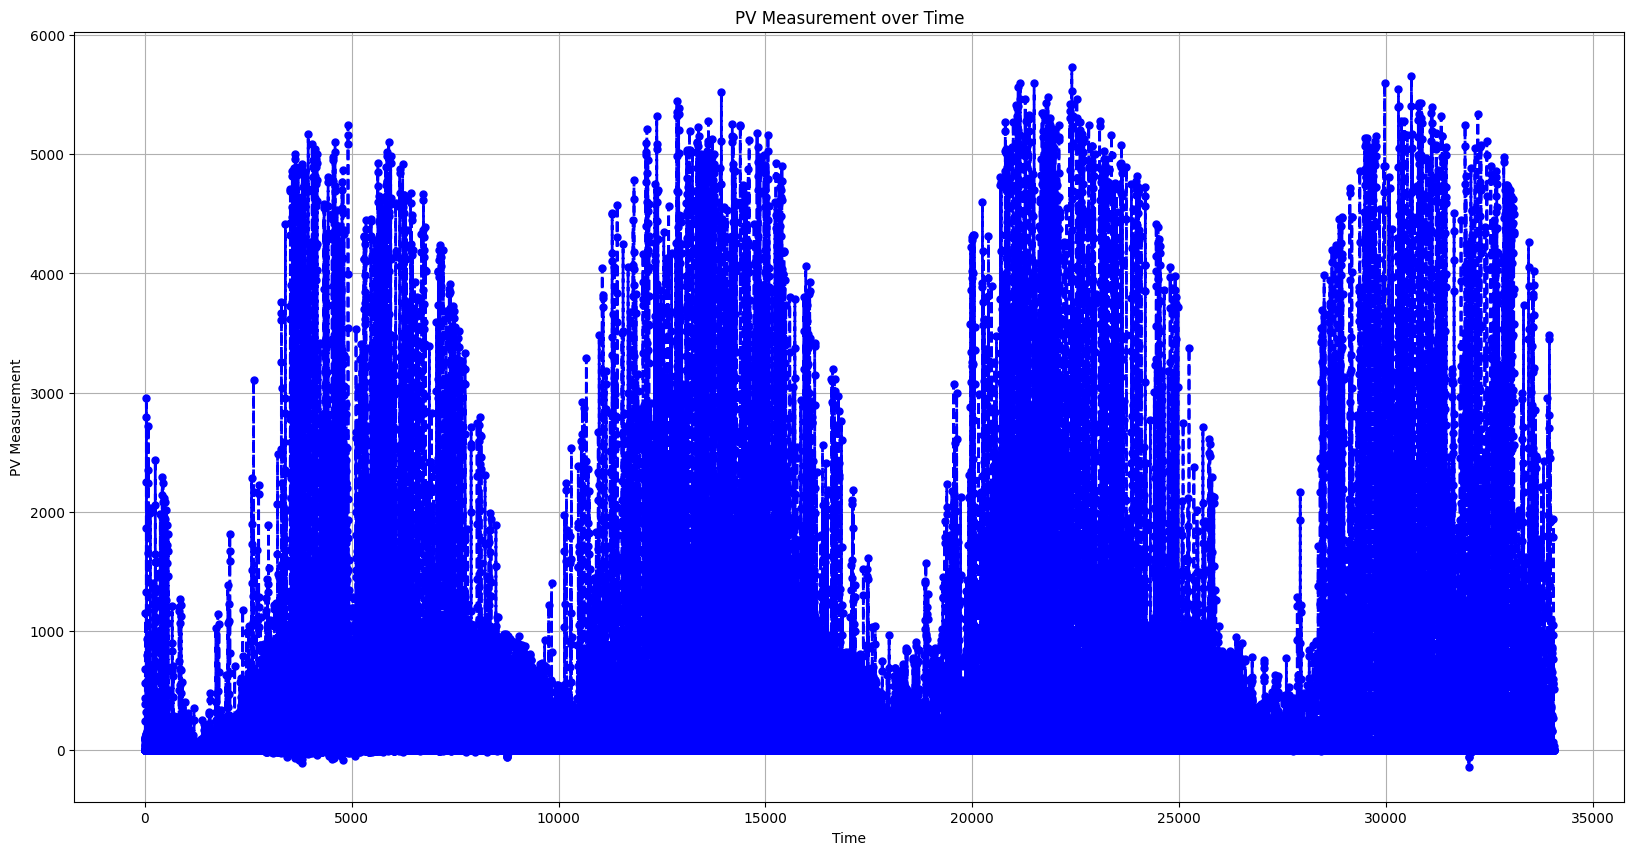

In [ ]:
import matplotlib.pyplot as plt

# your data
#y = new_data['pv_measurement']
print(len(y))
# create a new figure and axes
plt.figure(figsize=(20,10))

# create a line plot of 'pv_measurement'
plt.plot(y.index, y, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=5)

# give the plot a title and labels
plt.title('PV Measurement over Time')
plt.xlabel('Time')
plt.ylabel('PV Measurement')

# show grid
plt.grid(True)

# show the plot
plt.show()

In [ ]:
#1 model instead of 3

#adding location to cat_features
cat_features = ['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'location']

cat_model_combined = CatBoostRegressor(
    n_estimators=2000,
    thread_count=-1,
    max_depth=4,
    loss_function='RMSE',
    random_seed=42,
    od_type="Iter",
    early_stopping_rounds=20,
    logging_level='Verbose',
    cat_features=cat_features
)

# Train the model with the specified feature types
cat_model_combined.fit(X_train_combined, y_train_combined, cat_features=cat_features, eval_set=(X_validation_combined, y_validation_combined))

Learning rate set to 0.065625
0:	learn: 731.1527379	test: 720.7415200	best: 720.7415200 (0)	total: 64.7ms	remaining: 2m 9s
1:	learn: 695.7047932	test: 686.3276747	best: 686.3276747 (1)	total: 116ms	remaining: 1m 55s
2:	learn: 663.1673788	test: 654.6925041	best: 654.6925041 (2)	total: 168ms	remaining: 1m 51s
3:	learn: 633.4373778	test: 625.5846528	best: 625.5846528 (3)	total: 220ms	remaining: 1m 49s
4:	learn: 606.0853012	test: 598.8110435	best: 598.8110435 (4)	total: 270ms	remaining: 1m 47s
5:	learn: 579.8604112	test: 573.0093060	best: 573.0093060 (5)	total: 321ms	remaining: 1m 46s
6:	learn: 556.0759056	test: 549.5864642	best: 549.5864642 (6)	total: 370ms	remaining: 1m 45s
7:	learn: 533.4424355	test: 527.5435800	best: 527.5435800 (7)	total: 430ms	remaining: 1m 47s
8:	learn: 512.6430125	test: 507.1576799	best: 507.1576799 (8)	total: 485ms	remaining: 1m 47s
9:	learn: 493.5287993	test: 488.5503826	best: 488.5503826 (9)	total: 536ms	remaining: 1m 46s
10:	learn: 476.7633034	test: 472.2693616

In [ ]:
#managing the test data
X_test_a['location'] = 'A'
X_test_b['location'] = 'B'
X_test_c['location'] = 'C'

features_to_convert = ['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx']

# Convert features for X_test_a
for feature in features_to_convert:
    X_test_a[feature] = X_test_a[feature].apply(lambda x: int(x) if not pd.isna(x) else x)

# Convert features for X_test_b
for feature in features_to_convert:
    X_test_b[feature] = X_test_b[feature].apply(lambda x: int(x) if not pd.isna(x) else x)

# Convert features for X_test_c
for feature in features_to_convert:
    X_test_c[feature] = X_test_c[feature].apply(lambda x: int(x) if not pd.isna(x) else x)

nan_replacement = "missing_value"

# Replace NaN values in categorical features for X_test_a, X_test_b, and X_test_c
for feature in cat_features:
    X_test_a[feature].fillna(nan_replacement, inplace=True)
    X_test_b[feature].fillna(nan_replacement, inplace=True)
    X_test_c[feature].fillna(nan_replacement, inplace=True)

#1 model predictions, catboost

cat_features = ['dew_or_rime:idx', 'is_day:idx', 'is_in_shadow:idx', 'location']
# Convert predictions to numpy arrays for reshaping
cat_prediction_a = np.array(cat_model_combined.predict(X_test_a))
cat_prediction_b = np.array(cat_model_combined.predict(X_test_b))
cat_prediction_c = np.array(cat_model_combined.predict(X_test_c))

# Compute the mean of every 4 predictions
hourly_prediction_a = cat_prediction_a.reshape(-1, 4).mean(axis=1)
hourly_prediction_b = cat_prediction_b.reshape(-1, 4).mean(axis=1)
hourly_prediction_c = cat_prediction_c.reshape(-1, 4).mean(axis=1)

hourly_prediction_a = np.clip(hourly_prediction_a, 0, None)
hourly_prediction_b = np.clip(hourly_prediction_b, 0, None)
hourly_prediction_c = np.clip(hourly_prediction_c, 0, None)

num_predictions = len(hourly_prediction_a)
print(len(hourly_prediction_a))
timestamps = pd.date_range(start='2023-05-01 00:00:00', periods=num_predictions, freq='H')

# Step 1: Create individual DataFrames for each location
df_a = pd.DataFrame({
    'time': timestamps,
    'prediction': hourly_prediction_a,
    'location': 'A'
})

df_b = pd.DataFrame({
    'time': timestamps,
    'prediction': hourly_prediction_b,
    'location': 'B'
})

df_c = pd.DataFrame({
    'time': timestamps,
    'prediction': hourly_prediction_c,
    'location': 'C'
})

# Step 2: Concatenate these DataFrames
final_df = pd.concat([df_a, df_b, df_c], ignore_index=True)

# Step 3: Reset the index to get the 'id' column
final_df.reset_index(inplace=True)
final_df.rename(columns={'index': 'id'}, inplace=True)
print(final_df.dtypes)
# Now final_df is in the desired format
#print(final_df)
#print(final_df.columns)
final_df= final_df.drop(columns=['time', 'location'])

#print(final_df)
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)

720
id                     int64
time          datetime64[ns]
prediction           float64
location              object
dtype: object
